In [1]:
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

Thu Jan 23 17:03:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN RTX               Off |   00000000:A1:00.0 Off |                  N/A |
| 41%   33C    P8             16W /  280W |       6MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [3]:
import numpy as np

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [4]:
from datetime import datetime
import functools
from biped import Biped
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.io import model
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import mujoco
import numpy as np


import sys
sys.path.append('../')
from mujoco_playground import wrapper

from ml_collections import config_dict

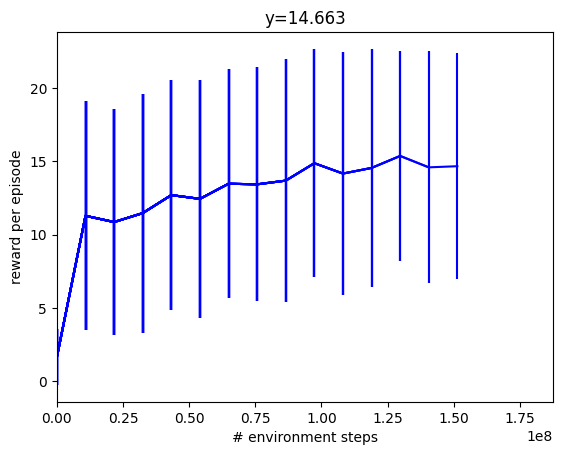

time to jit: 0:05:44.244921
time to train: 4:19:50.875131


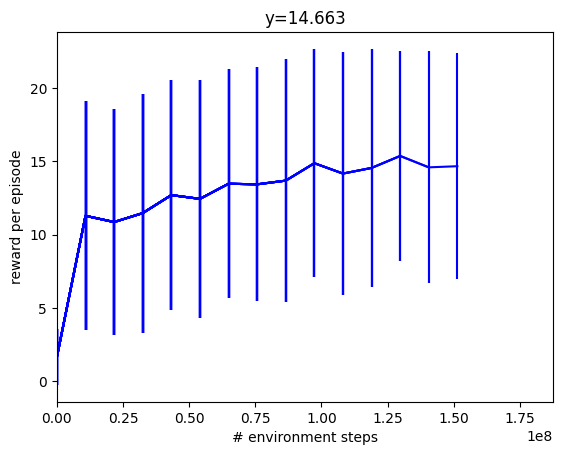

In [5]:

brax_ppo_config = config_dict.create(
      num_timesteps=150_000_000,
      num_evals=15,
      reward_scaling=1.0,
      clipping_epsilon=0.2,
      num_resets_per_eval=1,
      episode_length=1000,
      normalize_observations=True,
      action_repeat=1,
      unroll_length=20,
      num_minibatches=32,
      num_updates_per_batch=4,
      discounting=0.97,
      learning_rate=3e-4,
      entropy_cost=0.005,
      num_envs=8192,
      batch_size=256,
      max_grad_norm=1.0,
      network_factory = config_dict.create(
        policy_hidden_layer_sizes=(512, 256, 128),
        value_hidden_layer_sizes=(512, 256, 128),
        policy_obs_key="state",
        value_obs_key="privileged_state",
      ),   
  )
ppo_params = brax_ppo_config

env_name = 'Biped'
env = Biped()

x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")
  plt.savefig("ppo_training.png")

  display(plt.gcf())
  
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=None,
    progress_fn=progress
)

make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [7]:

#@title Rollout and Render
from utils import draw_joystick_command

eval_env = env
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))
print(f'JITing reset and step')
reset_fn = jax.jit(env.reset)
step_fn = jax.jit(env.step)

rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.ctrl_dt * 1.5
phase = jp.array([0, jp.pi])

for j in range(1):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  for i in range(1000):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env._mj_model.body("base_link").id])
    xyz += np.array([0, 0.0, 0])
    x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )

render_every = 1
fps = 1.0 / eval_env.ctrl_dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)

media.show_video(frames, fps=fps, loop=False)

JITing reset and step
episode 0
Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace>
Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace>
Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace>
Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace>
fps: 50.0


100%|██████████| 1000/1000 [00:03<00:00, 272.36it/s]


In [8]:
VIDEO_FOLDER = 'videos'
os.makedirs(VIDEO_FOLDER, exist_ok=True)
media.write_video(f'{VIDEO_FOLDER}/joystick.mp4', frames, fps=fps)

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
folder = 'runs/' + current_time

model.save_params('/tmp/params', params)
os.makedirs(folder, exist_ok=True)

if os.path.exists(folder):
    print("Directory created successfully")
else:
    print("Failed to create directory")

try:
    model.save_params(folder, params)
    print("Parameters saved successfully")
except Exception as e:
    print("Failed to save parameters:", str(e))
